# Cluster Analysis and Membership Probabilities

# 0.0 Imports

In [1]:
from astropy.io import fits
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn
import pickle
if("Analysis" in os.getcwd()):
    os.chdir("../")

from Data_handling.pca_functions import Pca_Fitting
from Data_handling.gaia_query import gaia_cone, bailer_jones_cone, concatenate_gaia_bailer
from Data_handling.vae import Encoder,Decoder, VAE , loss_function, model_train


os.chdir("Analysis")
os.getcwd()

'/Users/mattocallaghan/Documents/GES/Analysis'

# 1.0 Data input 

We are choosing the cluster NGC104 as Clare said.

# 1.1 For selected parameters
We open the GES iDR6 parameter file. This contains the working groups estimates of certain parameters and the distance derived from GAIA. First we create a data frame with a few parameters.

In [2]:
os.chdir('../Parameter_files')
par=fits.open('GES_iDR6_WG15_Recommended_with_sflags__mode_normal_091221.fits')
indices=[1,2,3,4,5,6,7,8,15,16,18,19,23,24,25,29,31,32,36,37,38,42,43,45,87,88]
columns=[par[1].header['TTYPE'+str(i)] for i in indices]
data=np.array([par[1].data[x] for x in columns]).transpose()
data=pd.DataFrame(data=data,columns=columns)

# 1.2 Cluster choice

Choosing a good globular cluster according to Clare's recommendation. 

Is this the best way of doing it. Finding the cluster in this way only looks at those stars which actually have spectra

In [3]:
GC=data[data['GES_FLD']=='NGC104'].reset_index()

#opening the files in the cluster 
with open('data_gaia.txt', 'w') as f:
    for item in GC['GAIA_eDR3_ID'].astype(str).values:
        f.write("%s\n" % item)

# 1.2.1 Overview of the globular cluster DF

In [4]:
GC.head(2)

,index,CNAME,CNAME_iDR6_orig,GAIA_eDR3_ID,DIST_GAIA,GES_FLD,OBJECT,FILENAME,GES_TYPE,RA,...,FEH,E_FEH,SYS_ERR_FEH,XI,E_XI,VRAD,E_VRAD,VRAD_OFFSET,GAMMA,E_GAMMA
0,1794,00212293-7205029,00212293-7205029,4689618925875604224,0.1034,NGC104,50005964,gir_00212293-7205029_H548.8.fit|gir_00212293-7...,GE_SD_GC,5.345458333333242,...,-0.77,0.07,nan,nan,nan,-9.03,0.19,nan,nan,nan
1,1799,00213442-7208534,00213442-7208534,4689614837066802944,0.0999,NGC104,6808,,AR_SD_GC,5.393416666667,...,nan,nan,nan,nan,nan,-11.52,0.36,0.59,nan,nan


# 1.3 Gaia Data input

Select region by taking the mean declination and RA, look at the diameter by chooisng the maximal degree separation.

In [5]:
ra=GC['RA'].astype(float)
dec=GC['DEC'].astype(float)

In [6]:
radiusd=np.abs(dec.max()-dec.min())
radiusr=np.abs(ra.max()-ra.min())
radius=np.sqrt(radiusr**2+radiusd**2)
center=[ra.mean(),dec.mean()]
radius

1.3587861642947656

Next we import the GAIA data for the selected region and concatenate it with the Bailer Jones posterior distance estimates.

In [7]:
selection_region=gaia_cone(center[0],center[1],radius*0.5)

bailer=bailer_jones_cone(center[0],center[1],radius*0.5)
selection_region=concatenate_gaia_bailer(selection_region,bailer)

Launched query: '
                SELECT
                  
                  *,
                  DISTANCE(
                    POINT('ICRS', ra, dec),
                    POINT('ICRS', 6.0253899470450785, -72.07755733533718)
                  ) AS dist
                FROM
                  gaiaedr3.gaia_source
                WHERE
                  1 = CONTAINS(
                    POINT('ICRS', ra, dec),
                    CIRCLE('ICRS', 6.0253899470450785, -72.07755733533718, 0.6793930821473828)
                  )
                ORDER BY
                  dist ASC
                '
------>https
host = gea.esac.esa.int:443
context = /tap-server/tap/async
Content-type = application/x-www-form-urlencoded
303 303
[('Date', 'Tue, 08 Feb 2022 13:58:04 GMT'), ('Server', 'Apache/2.4.6 (CentOS) OpenSSL/1.0.2k-fips PHP/5.4.16 mod_jk/1.2.43'), ('Cache-Control', 'no-cache, no-store, max-age=0, must-revalidate'), ('Pragma', 'no-cache'), ('Expires', '0'), ('X-XSS-Protection', '1; mode=block

# 1.4 Visualising the sample distribution
The red points are the objects idenitifed in the GES survey. Blue are the total objects from the GAIA survey.

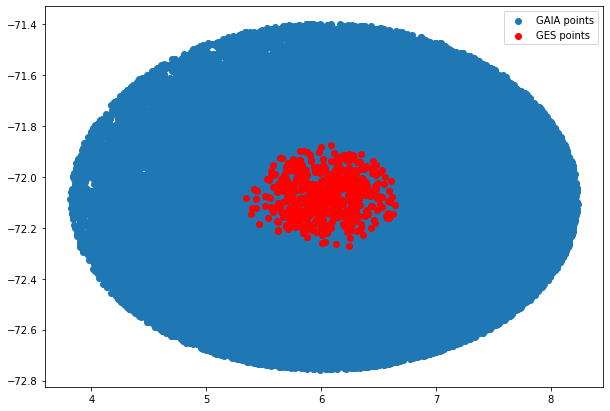

In [8]:
plt.figure(figsize=(10,7))
plt.scatter(x=selection_region['ra'],y=selection_region['dec'],label='GAIA points')
plt.scatter(x=ra,y=dec,color='red',label='GES points')
plt.legend()

In [9]:
GC['GAIA_eDR3_ID']=GC['GAIA_eDR3_ID'].astype(int)

In [10]:
selection_region['GAIA_eDR3_ID']=selection_region['source_id']

In [11]:
gaia_df_gc=selection_region[selection_region['GAIA_eDR3_ID'].isin(GC['GAIA_eDR3_ID'].astype(int).values)]


# 1.5 Merge the dataframe from the Gaia import and the dataframe created from the parameter files.

In [12]:
globular_cluster_data=pd.DataFrame.merge(GC, gaia_df_gc,on='GAIA_eDR3_ID')


# 1.6 Plotting Parameter Distribution

Plot the distribution of the derived parameters in the cluster folder.

Text(0.5, 1.0, 'Plot in proper motion space')

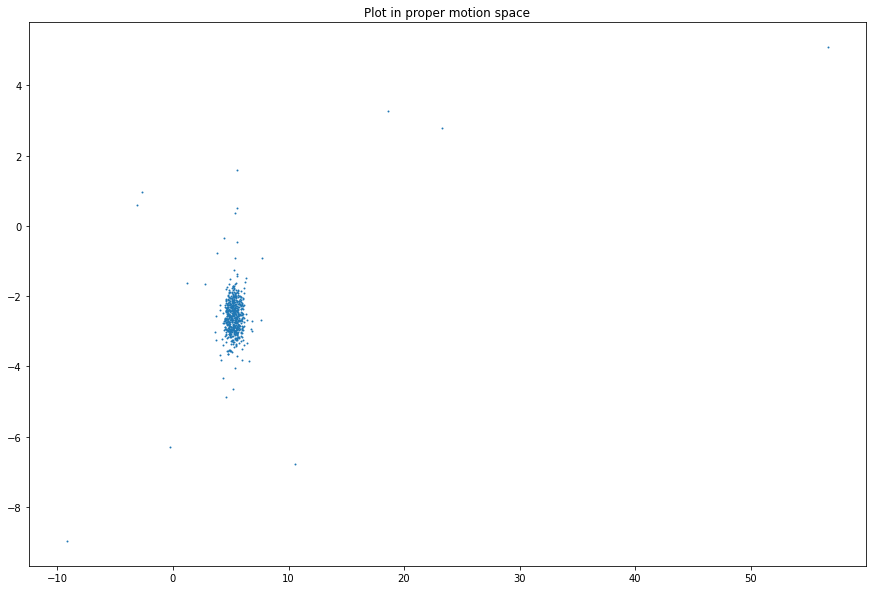

In [13]:
plt.figure(figsize=(15,10))
plt.scatter(globular_cluster_data['pmra'],globular_cluster_data['pmdec'],s=0.9)
plt.title('Plot in proper motion space')

Text(0.5, 1.0, 'bp_rp histogram plot')

<Figure size 1080x720 with 0 Axes>

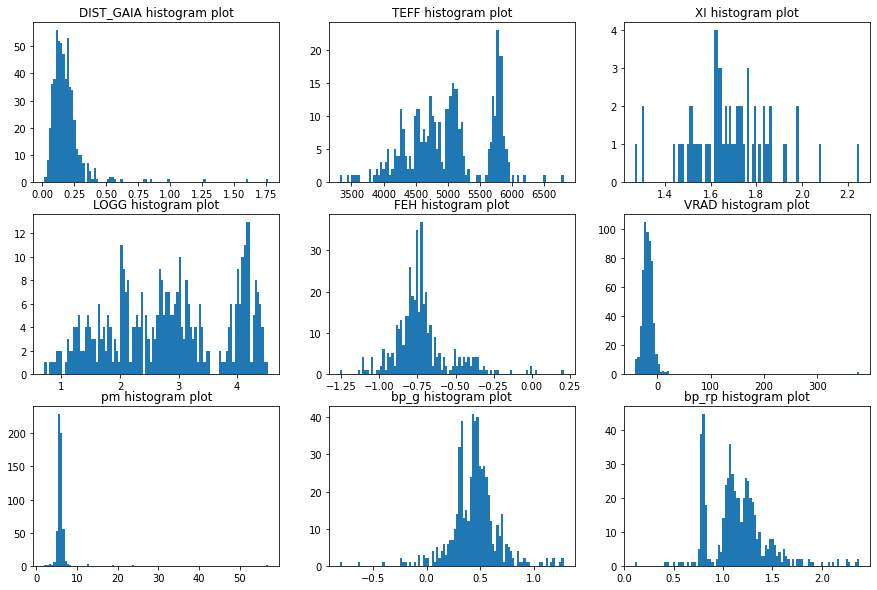

In [14]:

par=['DIST_GAIA','TEFF', 'LOGG', 'FEH', 'VRAD', 'XI','pm','bp_g','bp_rp','g_rp']
plt.figure(figsize=(15,10))
globular_cluster_data[par]=globular_cluster_data[par].astype(float)
fig, axs = plt.subplots(3, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
axs[0, 0].hist(globular_cluster_data[par[0]].astype(float),bins=100)
axs[0, 0].set_title(par[0] + ' histogram plot')
axs[0, 1].hist(globular_cluster_data[par[1]].astype(float),bins=100)
axs[0, 1].set_title(par[1] + ' histogram plot')
axs[1, 0].hist(globular_cluster_data[par[2]].astype(float),bins=100)
axs[1, 0].set_title(par[2] + ' histogram plot')
axs[1, 1].hist(globular_cluster_data[par[3]].astype(float),bins=100)
axs[1, 1].set_title(par[3] + ' histogram plot')
axs[1, 2].hist(globular_cluster_data[par[4]].astype(float),bins=100)
axs[1, 2].set_title(par[4] + ' histogram plot')
axs[0, 2].hist(globular_cluster_data[par[5]].dropna().astype(float),bins=100)
axs[0, 2].set_title(par[5] + ' histogram plot')


axs[2, 0].hist(globular_cluster_data[par[6]].astype(float),bins=100)
axs[2, 0].set_title(par[6] + ' histogram plot')
axs[2, 1].hist(globular_cluster_data[par[7]].astype(float),bins=100)
axs[2, 1].set_title(par[7] + ' histogram plot')
axs[2, 2].hist(globular_cluster_data[par[8]].astype(float),bins=100)
axs[2, 2].set_title(par[8] + ' histogram plot')


# 1.6.1 Density plot of different parameters

(-2.0, 10.0)

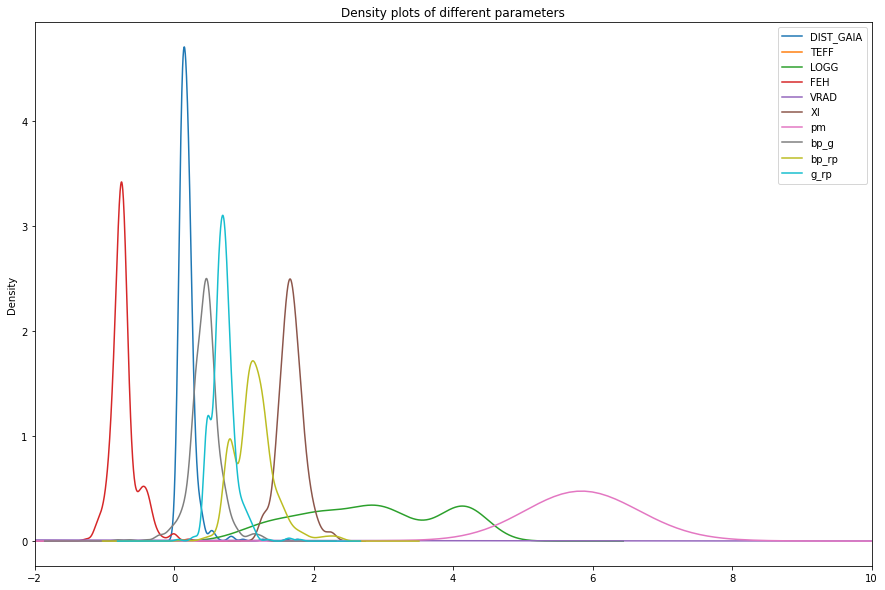

In [15]:
par=['DIST_GAIA','TEFF', 'LOGG', 'FEH', 'VRAD', 'XI','pm','bp_g','bp_rp','g_rp']
globular_cluster_data[par].plot.kde(figsize=(15,10),title='Density plots of different parameters')
plt.xlim(-2,10)

# 1.6.2 Density plot of just the GAIA Parameters

(-2.0, 10.0)

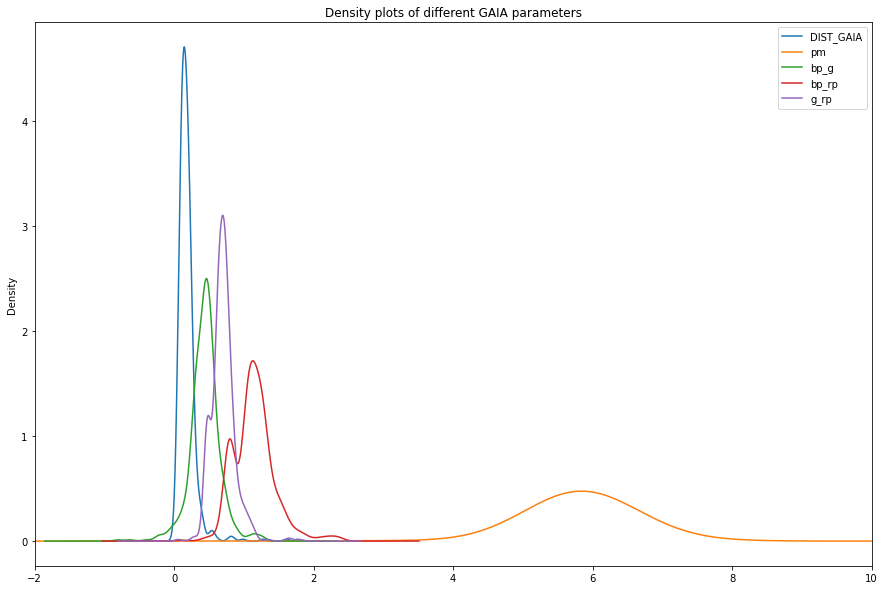

In [16]:
par=['DIST_GAIA','pm','bp_g','bp_rp','g_rp']
globular_cluster_data[par].plot.kde(figsize=(15,10),title='Density plots of different GAIA parameters')
plt.xlim(-2,10)

# 1.6.3 Distribution of GES Parameters

(-2.0, 10.0)

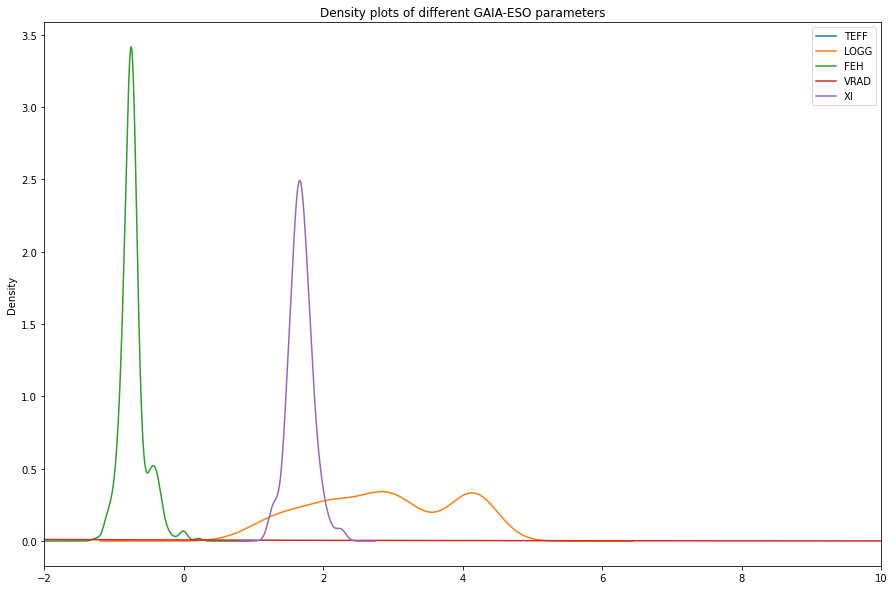

In [17]:
par=['TEFF', 'LOGG', 'FEH', 'VRAD', 'XI']
globular_cluster_data[par].plot.kde(figsize=(15,10),title='Density plots of different GAIA-ESO parameters')
plt.xlim(-2,10)

<AxesSubplot:title={'center':'Density plots of VRAD parameters'}, ylabel='Density'>

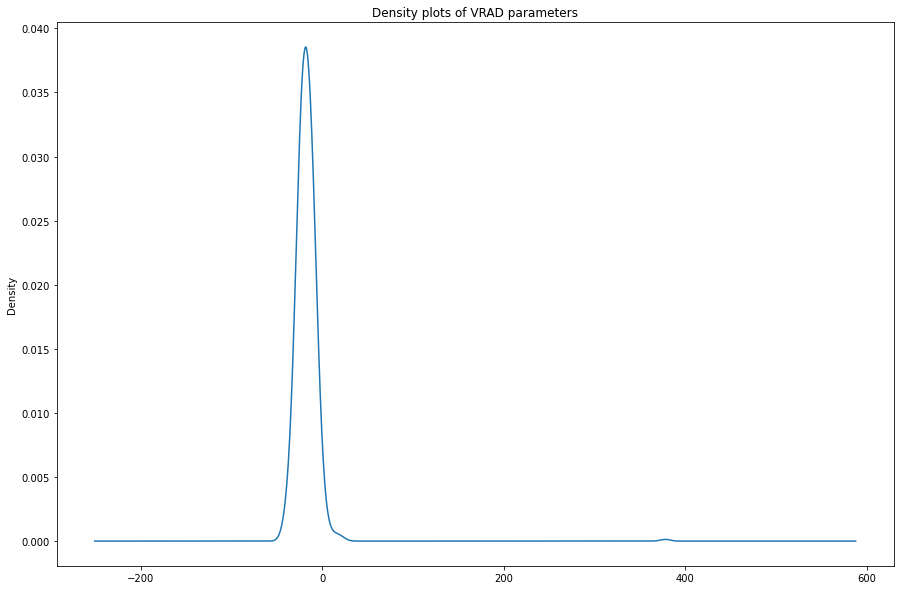

In [18]:
par='VRAD'
globular_cluster_data[par].plot.kde(figsize=(15,10),title='Density plots of VRAD parameters')


# 2.0 Fitting Probability Distributions to the Data

# 2.1 Gaussian Fit for each component

Text(0.5, 1.0, 'bp_rp gaussian fit')

<Figure size 1080x720 with 0 Axes>

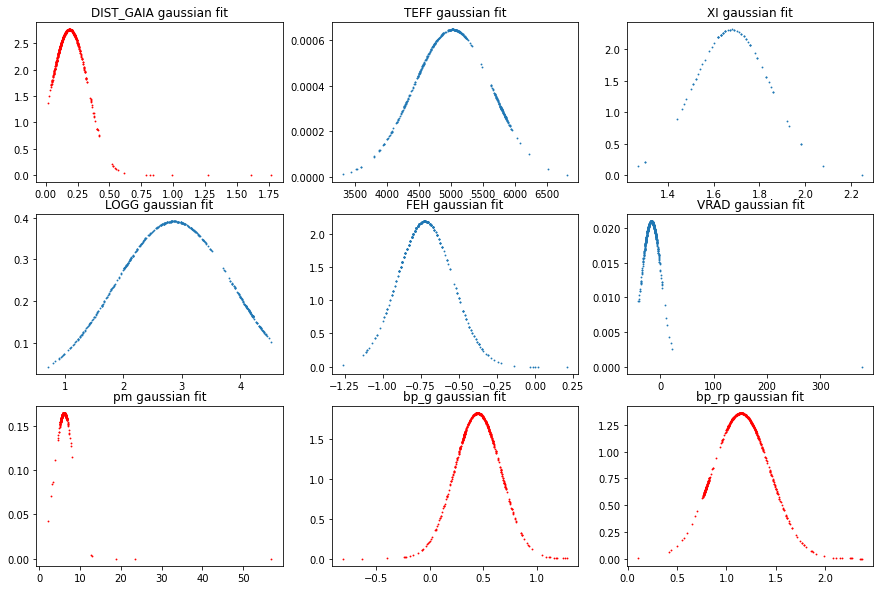

In [19]:
from scipy.stats import multivariate_normal

par=['DIST_GAIA','TEFF', 'LOGG', 'FEH', 'VRAD', 'XI','pm','bp_g','bp_rp','g_rp']
plt.figure(figsize=(15,10))

def plot_data(gaia_par):
    learning_data=globular_cluster_data[gaia_par].dropna().to_numpy()
    cov=np.cov(learning_data.transpose())

    mean=np.mean(learning_data,axis=0)

    y = multivariate_normal.pdf(learning_data, mean=mean, cov=cov)
    return learning_data , y


fig, axs = plt.subplots(3, 3)
fig.set_figwidth(15)
fig.set_figheight(10)

x,y=plot_data(par[0])
axs[0, 0].scatter(x=x,y=y,s=0.7,color='r')
axs[0, 0].set_title(par[0] + ' gaussian fit')

x,y=plot_data(par[1])
axs[0, 1].scatter(x=x,y=y,s=0.7)
axs[0, 1].set_title(par[1] + ' gaussian fit')

x,y=plot_data(par[2])
axs[1, 0].scatter(x=x,y=y,s=0.7)
axs[1, 0].set_title(par[2] + ' gaussian fit')

x,y=plot_data(par[3])
axs[1, 1].scatter(x=x,y=y,s=0.7)
axs[1, 1].set_title(par[3] + ' gaussian fit')

x,y=plot_data(par[4])
axs[1, 2].scatter(x=x,y=y,s=0.7)
axs[1, 2].set_title(par[4] + ' gaussian fit')

x,y=plot_data(par[5])
axs[0, 2].scatter(x=x,y=y,s=0.7)
axs[0, 2].set_title(par[5] + ' gaussian fit')


x,y=plot_data(par[6])
axs[2, 0].scatter(x=x,y=y,s=0.7,color='r')
axs[2, 0].set_title(par[6] + ' gaussian fit')

x,y=plot_data(par[7])
axs[2, 1].scatter(x=x,y=y,s=0.7,color='r')
axs[2, 1].set_title(par[7] + ' gaussian fit')

x,y=plot_data(par[8])
axs[2, 2].scatter(x=x,y=y,s=0.7,color='r')
axs[2, 2].set_title(par[8] + ' gaussian fit')

# 2.1.1 Cumultive Dist Function for the Above Fit

Text(0.5, 1.0, 'bp_rp gaussian fit')

<Figure size 1080x720 with 0 Axes>

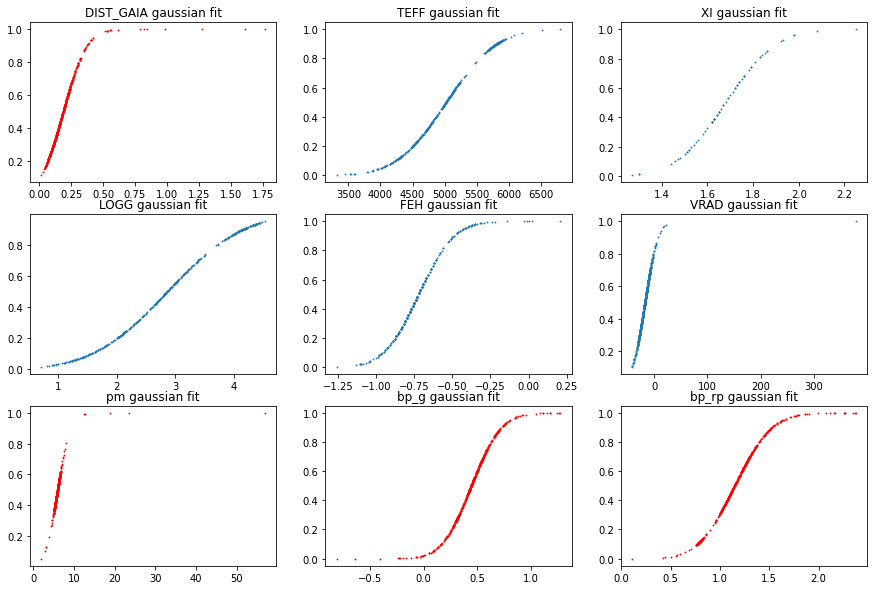

In [20]:
from scipy.stats import multivariate_normal

par=['DIST_GAIA','TEFF', 'LOGG', 'FEH', 'VRAD', 'XI','pm','bp_g','bp_rp','g_rp']
plt.figure(figsize=(15,10))

def plot_data(gaia_par):
    learning_data=globular_cluster_data[gaia_par].dropna().to_numpy()
    cov=np.cov(learning_data.transpose())

    mean=np.mean(learning_data,axis=0)

    y = multivariate_normal.cdf(learning_data, mean=mean, cov=cov)
    return learning_data , y


fig, axs = plt.subplots(3, 3)
fig.set_figwidth(15)
fig.set_figheight(10)

x,y=plot_data(par[0])
axs[0, 0].scatter(x=x,y=y,s=0.7,color='r')
axs[0, 0].set_title(par[0] + ' gaussian fit')

x,y=plot_data(par[1])
axs[0, 1].scatter(x=x,y=y,s=0.7)
axs[0, 1].set_title(par[1] + ' gaussian fit')

x,y=plot_data(par[2])
axs[1, 0].scatter(x=x,y=y,s=0.7)
axs[1, 0].set_title(par[2] + ' gaussian fit')

x,y=plot_data(par[3])
axs[1, 1].scatter(x=x,y=y,s=0.7)
axs[1, 1].set_title(par[3] + ' gaussian fit')

x,y=plot_data(par[4])
axs[1, 2].scatter(x=x,y=y,s=0.7)
axs[1, 2].set_title(par[4] + ' gaussian fit')

x,y=plot_data(par[5])
axs[0, 2].scatter(x=x,y=y,s=0.7)
axs[0, 2].set_title(par[5] + ' gaussian fit')


x,y=plot_data(par[6])
axs[2, 0].scatter(x=x,y=y,s=0.7,color='r')
axs[2, 0].set_title(par[6] + ' gaussian fit')

x,y=plot_data(par[7])
axs[2, 1].scatter(x=x,y=y,s=0.7,color='r')
axs[2, 1].set_title(par[7] + ' gaussian fit')

x,y=plot_data(par[8])
axs[2, 2].scatter(x=x,y=y,s=0.7,color='r')
axs[2, 2].set_title(par[8] + ' gaussian fit')

# 2.2 Fitting Joint Gaussians to the Data

Text(0.5, 1.0, 'CDF Joint Dist')

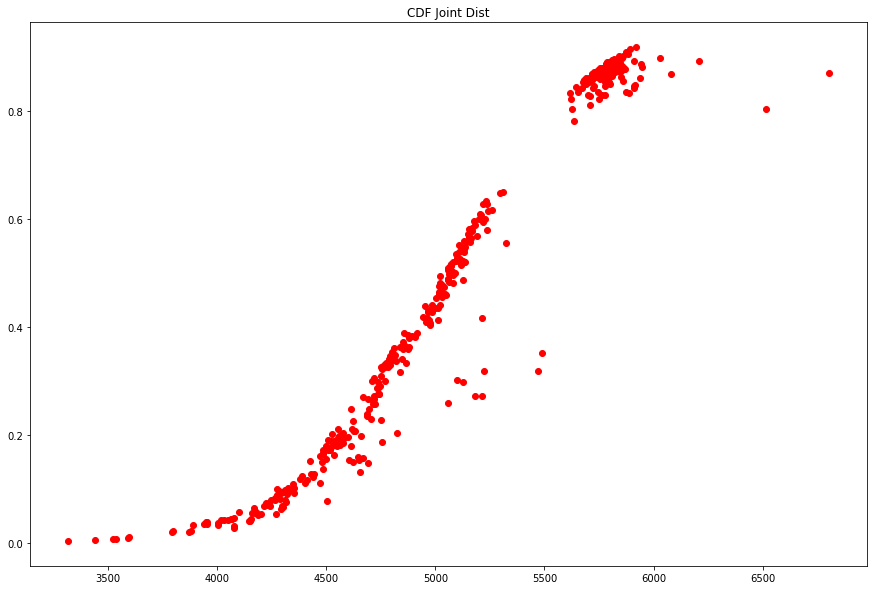

In [21]:
from scipy.stats import multivariate_normal

par=['DIST_GAIA','TEFF', 'LOGG', 'FEH', 'VRAD', 'XI','pm','bp_g','bp_rp','g_rp']
plt.figure(figsize=(15,10))

def plot_data(gaia_par):
    learning_data=globular_cluster_data[gaia_par].dropna().to_numpy()
    cov=np.cov(learning_data.transpose())

    mean=np.mean(learning_data,axis=0)

    y = multivariate_normal.cdf(learning_data, mean=mean, cov=cov)
    return learning_data , y

x,y=plot_data(['TEFF','LOGG'])

plt.scatter(x=x.transpose()[0],y=y,color='r')
plt.title('CDF Joint Dist')


# 3.0 Colour Magnitude and Colour Colour Diagrams

Can compare this to Gaia Data Release 2: Observational Hertzsprung-Russell diagrams
https://www.researchgate.net/publication/324769514_Gaia_Data_Release_2_Observational_Hertzsprung-Russell_diagrams?enrichId=rgreq-3e5e72aa410c5209f80944411f2e8d84-XXX&enrichSource=Y292ZXJQYWdlOzMyNDc2OTUxNDtBUzo2MjYxMjE5MDUyNzQ4ODFAMTUyNjI5MDUwMzY2OQ%3D%3D&el=1_x_2&_esc=publicationCoverPdf

/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_49570/3125847033.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection_gaia['mean_absolute_mag_g_band']=selection_gaia['phot_g_mean_mag']-2.5*np.log10((selection_gaia['rgeo']/10.0)**2)


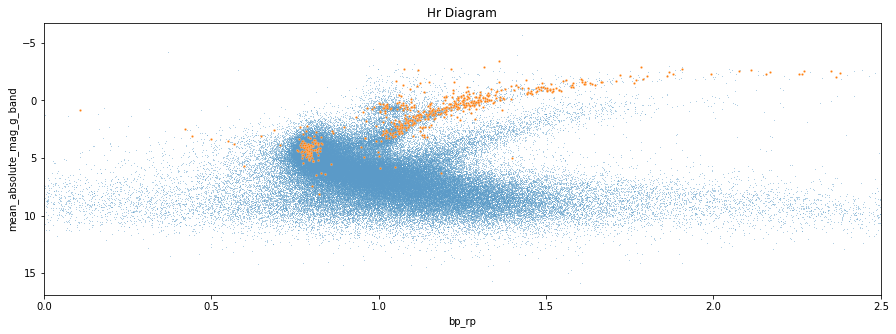

In [22]:
def mean_basolute_mag_g_band(selection_gaia):

    selection_gaia['mean_absolute_mag_g_band']=selection_gaia['phot_g_mean_mag']-2.5*np.log10((selection_gaia['rgeo']/10.0)**2)
    return selection_gaia




f, axes = plt.subplots(1, 1)

f.set_figheight(5)
f.set_figwidth(15)
scatter=mean_basolute_mag_g_band(selection_region[selection_region['pm']<=15])
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=0.5)

scatter=mean_basolute_mag_g_band(globular_cluster_data)
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=5)

axes.set_xlim(0,2.5)

axes.invert_yaxis()
axes.set_title("Hr Diagram")
plt.show()

https://www.researchgate.net/profile/C-Ordenovic/publication/324769514/figure/fig4/AS:619506787442688@1524713336185/Comparison-between-the-HRDs-of-47-Tuc-NGC-104-Age1275-Gyr-Fe-H-072-one-of-the.png

# 3.1 Fit Isochrones

# 4.0 Gaussian Mixture Model


# 4.1 Proper motion, radial distance.

If we look at the distributions above we see that the gaia distance, proper motion, metallicity is bell shaped so we will fiit those.

In [69]:
from sklearn.mixture import GaussianMixture
gmm=GaussianMixture(n_components=2).fit(globular_cluster_data[['rgeo','pmdec','pmra']].dropna().to_numpy())

The reason we use these three variables here is that every element in the file has them

For other variables we need to consider replacing datapoints.

In [70]:
probs=gmm.predict_proba(globular_cluster_data[['rgeo','pmdec','pmra']].dropna().to_numpy())

In [71]:
globular_cluster_data['member80']=(probs.transpose()[1]>=0.8)
globular_cluster_data['member70']=(probs.transpose()[1]>=0.7)
globular_cluster_data['member90']=(probs.transpose()[1]>=0.9)
globular_cluster_data['member92']=(probs.transpose()[1]>=0.92)
globular_cluster_data['member95']=(probs.transpose()[1]>=0.95)
globular_cluster_data['member99']=(probs.transpose()[1]>=0.99)

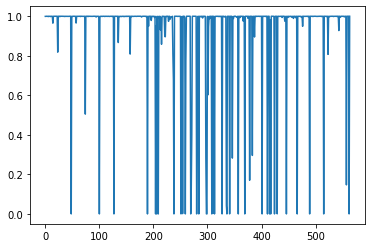

In [73]:
plt.plot(probs.transpose()[1])

Text(0.5, 1.0, 'Plot in proper motion space')

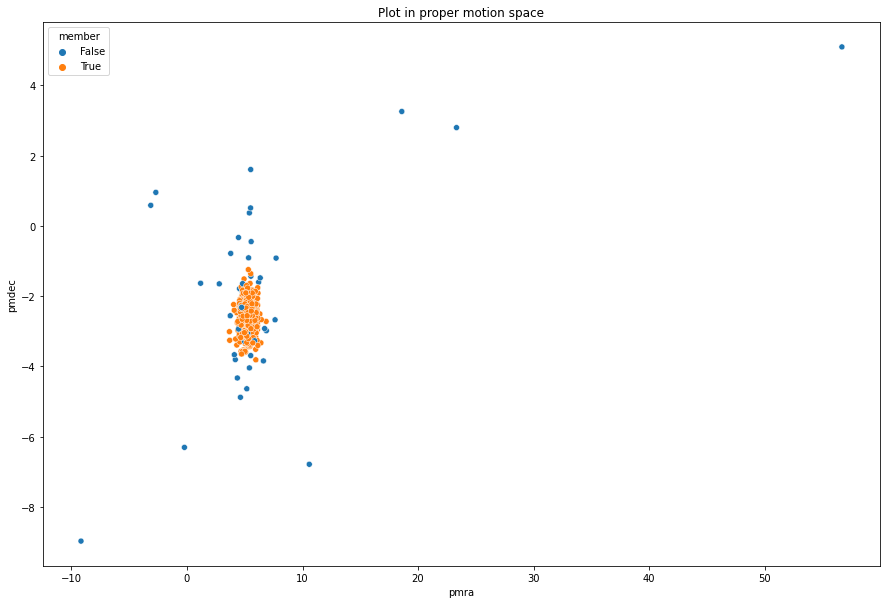

In [74]:
plt.figure(figsize=(15,10))
sn.scatterplot(data=globular_cluster_data,x='pmra',y='pmdec',hue='member')
plt.title('Plot in proper motion space')

Text(0.5, 1.0, '486selected out of 564')

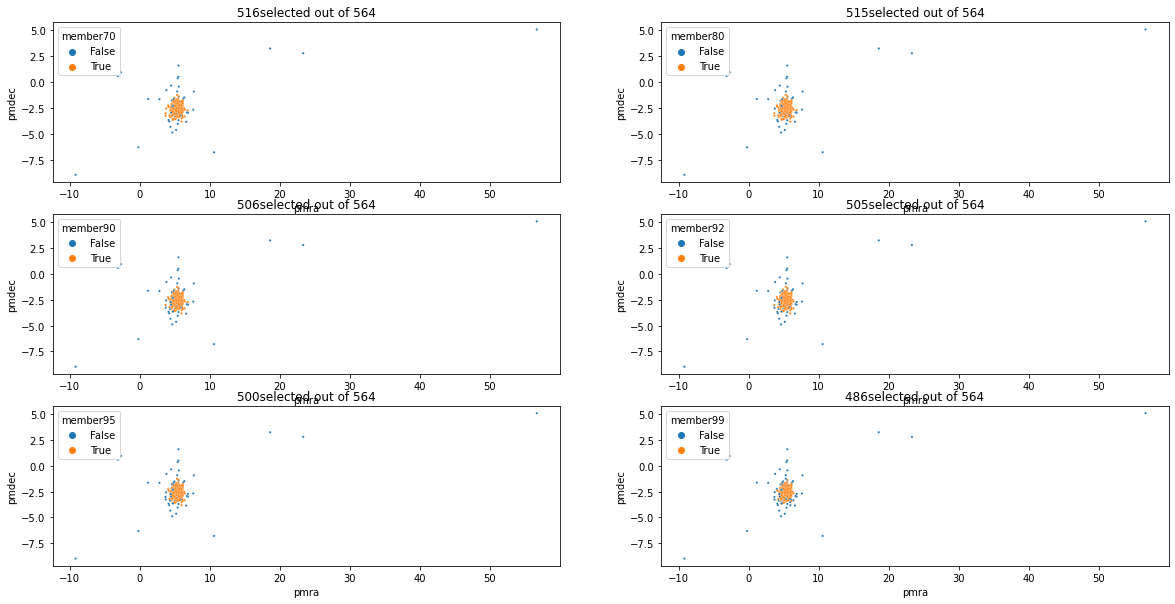

In [75]:


fig, axs = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(10)


sn.scatterplot(data=globular_cluster_data,x='pmra',y='pmdec',hue='member70',ax=axs[0,0],s=5)
axs[0, 0].set_title(str(sum(probs.transpose()[1]>=0.7)) + 'selected out of ' + str(len(probs.transpose()[1])))

sn.scatterplot(data=globular_cluster_data,x='pmra',y='pmdec',hue='member80',ax=axs[0,1],s=5)
axs[0, 1].set_title(str(sum(probs.transpose()[1]>=0.8)) + 'selected out of ' + str(len(probs.transpose()[1])))

sn.scatterplot(data=globular_cluster_data,x='pmra',y='pmdec',hue='member90',ax=axs[1,0],s=5)
axs[1, 0].set_title(str(sum(probs.transpose()[1]>=0.9)) + 'selected out of ' + str(len(probs.transpose()[1])))

sn.scatterplot(data=globular_cluster_data,x='pmra',y='pmdec',hue='member92',ax=axs[1,1],s=5)
axs[1, 1].set_title(str(sum(probs.transpose()[1]>=0.92)) + 'selected out of ' + str(len(probs.transpose()[1])))

sn.scatterplot(data=globular_cluster_data,x='pmra',y='pmdec',hue='member95',ax=axs[2,0],s=5)
axs[2, 0].set_title(str(sum(probs.transpose()[1]>=0.95)) + 'selected out of ' + str(len(probs.transpose()[1])))

sn.scatterplot(data=globular_cluster_data,x='pmra',y='pmdec',hue='member99',ax=axs[2,1],s=5)
axs[2, 1].set_title(str(sum(probs.transpose()[1]>=0.99)) + 'selected out of ' + str(len(probs.transpose()[1])))



# What about missing data

In [30]:
plot_data=globular_cluster_data[probs.transpose()[1]<=0.99]

plt.figure(figsize=(15,10))
plt.scatter(globular_cluster_data['pmra'],globular_cluster_data['pmdec'],s=0.9)
plt.title('Plot in proper motion space')

ValueError: Item wrong length 402 instead of 564.

In [ ]:
sum([1==probs.transpose()[1][i] for i in range(len(probs.transpose()[1]))])

1

In [ ]:
par=['DIST_GAIA','TEFF', 'LOGG', 'FEH', 'VRAD', 'XI','pm','bp_g','bp_rp','g_rp']
learning_data=globular_cluster_data[par[0:2]].dropna().to_numpy()

In [ ]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel="gaussian", bandwidth=0.75).fit(learning_data)

# 3.0 Cross matching 

The parameter file already has cross matching with GAIA.